# Day 2 — Stock Return Distributions & Hypothesis Testing

#### **Goals:**
#### - Understand distributions: normal, lognormal, Student's t
#### - Compute expectation, variance, covariance, correlation from data
#### - Build a 2-asset portfolio and compute return & risk
#### - Run hypothesis tests (one- and two-tailed), and interpret p-values
####

In [1]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


# make plots look consistent
plt.style.use('default')

#### 1) Quick sanity: simulate distributions and plot PDFs

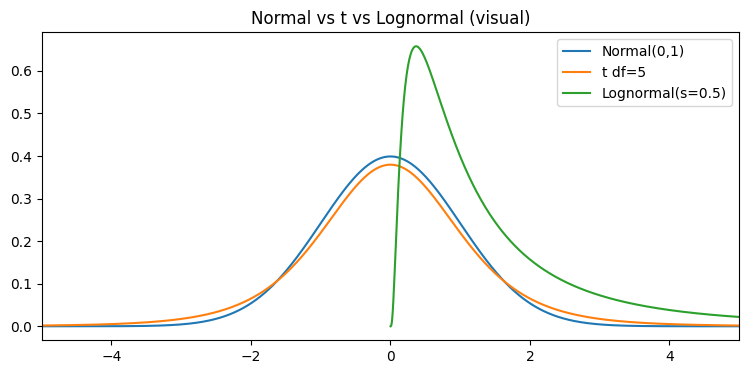

In [9]:
# baseline x-range
x = np.linspace(-5, 5, 1000)


# normal(0,1)
pdf_normal = stats.norm.pdf(x, 0, 1)


# t-distribution with df=5
pdf_t5 = stats.t.pdf(x, df=5) # Degrees of freedom is a crucial thing to understand here, as it increases, it simulates a gaussian


# lognormal: we will plot on positive x only
x_pos = np.linspace(0.001, 10, 1000)
# shape s = sigma of underlying normal; here s=0.5
pdf_lognorm = stats.lognorm.pdf(x_pos, s=1)


plt.figure(figsize=(9,4))
plt.plot(x, pdf_normal, label='Normal(0,1)')
plt.plot(x, pdf_t5, label='t df=5')
plt.plot(x_pos, pdf_lognorm, label='Lognormal(s=0.5)')
plt.xlim(-5,5)
plt.legend(); plt.title('Normal vs t vs Lognormal (visual)')
plt.show()

P(heads)=0.4972, P(tails)=0.5028
P(heads)=0.4080, P(tails)=0.5920


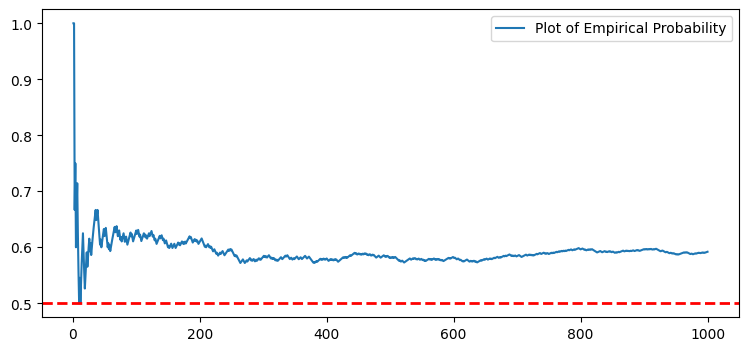

In [107]:
flips = np.random.choice([0,1], size=10000) # 0=heads, 1=tails
p_heads = np.mean(flips==0)
p_tails = np.mean(flips==1)
print(f"P(heads)={p_heads:.4f}, P(tails)={p_tails:.4f}")




# Simulating a weighted coin
coin_faces = [0, 1]
weights = [0.4 , 0.6]

import random
coin_outcomes = np.array(random.choices(coin_faces, weights=weights, k=1000))
p_heads = np.mean(coin_outcomes==0)
p_tails = np.mean(coin_outcomes==1)
print(f"P(heads)={p_heads:.4f}, P(tails)={p_tails:.4f}")


total = 0
points = []
for index, flip in enumerate(coin_outcomes):
    if flip ==1 : 
        total = total +1
        cum_mean = total/(index+1)
        points.append(cum_mean)
    else:
        cum_mean = total/(index+1)
        points.append(cum_mean)


plt.figure(figsize=(9,4))
plt.plot(range(1,len(coin_outcomes)+1), points, label='Plot of Empirical Probability')
plt.axhline(y=0.5, color='r', linestyle='--', linewidth=2)
plt.legend()
plt.show()

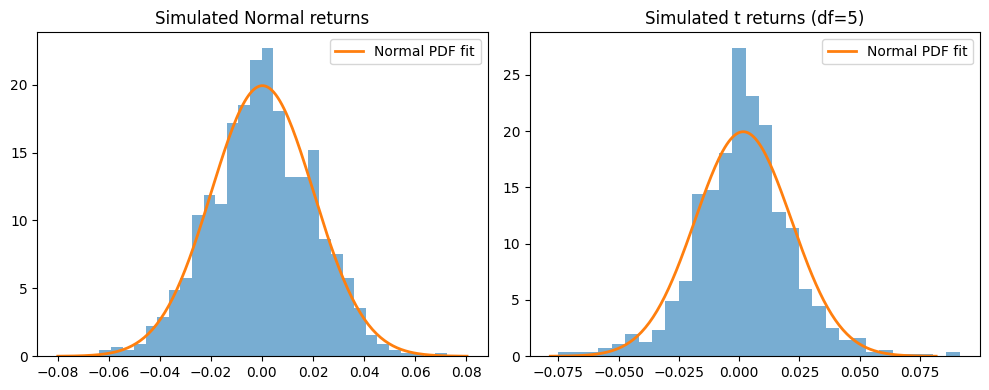

The normal distributions kurtosis is  -0.02543852877769215
The t-distributed distributions kurtosis is  1.7116669893547316


In [ ]:
np.random.seed(123)
n = 1000
# normal returns: mean 0.1% , daily volatility 2%
sim_normal = np.random.normal(loc=0.001, scale=0.02, size=n)


# t-distributed returns: generate from standard t and scale to have approx std=0.02
# pick df = 5 (heavy tails)
df = 5
raw_t = stats.t.rvs(df=df, size=n)
# scale raw_t to have standard deviation ~0.02 (approx)
scale_factor = 0.02 / np.std(raw_t)
sim_t = raw_t * scale_factor + 0.001 # add same mean


# quick histograms
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(sim_normal, bins=30, density=True, alpha=0.6)
mu_n, sd_n = np.mean(sim_normal), np.std(sim_normal, ddof=1)
xn = np.linspace(mu_n - 4*sd_n, mu_n + 4*sd_n, 200)
plt.plot(xn, stats.norm.pdf(xn, mu_n, sd_n), lw=2, label='Normal PDF fit')
plt.title('Simulated Normal returns')
plt.legend()


plt.subplot(1,2,2)
plt.hist(sim_t, bins=30, density=True, alpha=0.6)
mu_t, sd_t = np.mean(sim_t), np.std(sim_t, ddof=1)
xt = np.linspace(mu_t - 4*sd_t, mu_t + 4*sd_t, 200)
plt.plot(xt, stats.norm.pdf(xt, mu_t, sd_t), lw=2, label='Normal PDF fit')
plt.title(f'Simulated t returns (df={df})')
plt.legend()
plt.tight_layout(); plt.show()


# kurtosis measurement to compare relative to normal distribution
normal_kurtosis = stats.kurtosis(a=sim_normal)
print("The normal distributions kurtosis is ", normal_kurtosis)

t_kurtosis = stats.kurtosis(a=sim_t)
print("The t-distributed distributions kurtosis is ", t_kurtosis)

# Higher kurtosis means more probability mass in the tails, which means more extreme events, most prevalent in t-distributions.


In [120]:
import yfinance as yf
import warnings

warnings.filterwarnings(action='ignore')

df = yf.download("AAPL", start='2024-01-01', end='2024-12-31')


[*********************100%***********************]  1 of 1 completed


Ticker          AAPL
Date                
2024-01-02  0.000000
2024-01-03 -0.007488
2024-01-04 -0.012700
2024-01-05 -0.004013
2024-01-08  0.024175
The kurtosis of AAPL's returns is  [3.6605968]


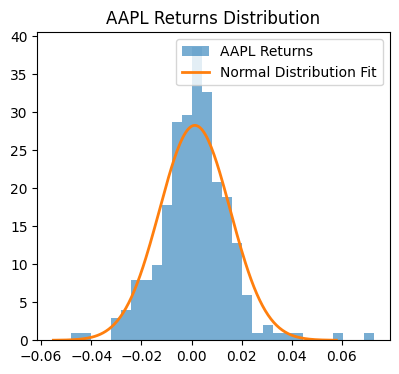

In [132]:
simple_returns = df['Close'].pct_change()
simple_returns = simple_returns.fillna(0)  # Fill NaN values FIRST

# quick histograms
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(simple_returns, bins=30, density=True, alpha=0.6, label='AAPL Returns')
mu_n, sd_n = np.mean(simple_returns), np.std(simple_returns, ddof=1)
xn = np.linspace(mu_n - 4*sd_n, mu_n + 4*sd_n, 200)
plt.plot(xn, stats.norm.pdf(xn, mu_n, sd_n), lw=2, label='Normal Distribution Fit')
plt.title('AAPL Returns Distribution')
plt.legend()

print(simple_returns.head())
print("The kurtosis of AAPL's returns is ", stats.kurtosis(a=simple_returns))

Ticker      AAPL
Date            
2024-01-02   0.0
2024-01-03   0.0
2024-01-04   0.0
2024-01-05   0.0
2024-01-08   0.0
The kurtosis of AAPL's returns is  [0.40879739]


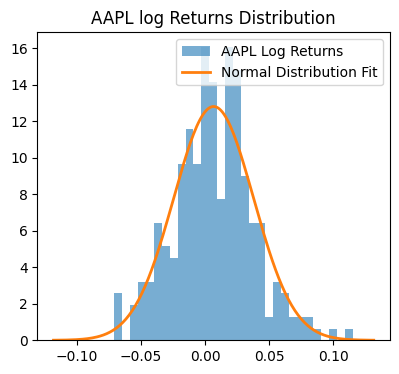

In [139]:
log_returns = np.log(df['Close'] / df['Close'].shift(5))
log_returns = log_returns.fillna(0)

# quick histograms
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(log_returns, bins=30, density=True, alpha=0.6, label='AAPL Log Returns')
mu_n, sd_n = np.mean(log_returns), np.std(log_returns, ddof=1)
xn = np.linspace(mu_n - 4*sd_n, mu_n + 4*sd_n, 200)
plt.plot(xn, stats.norm.pdf(xn, mu_n, sd_n), lw=2, label='Normal Distribution Fit')
plt.title('AAPL log Returns Distribution')
plt.legend()

print(log_returns.head())
print("The kurtosis of AAPL's returns is ", stats.kurtosis(a=log_returns))


In [ ]:
np.random.seed(44)
# base noise
z = np.random.normal(0, 0.02, size=n)
# asset A
returns_A = 0.001 + z
# asset B correlated with A
returns_B = 0.8 * returns_A + np.random.normal(0, 0.015, size=n)


# sample expectations (means)
mean_A = np.mean(returns_A)
mean_B = np.mean(returns_B)
print('mean_A, mean_B =', mean_A, mean_B)


# sample variances (use ddof=1 for unbiased)
var_A = np.var(returns_A, ddof=1)
var_B = np.var(returns_B, ddof=1)
print('var_A, var_B =', var_A, var_B)


# sample covariance and correlation
cov_AB = np.cov(returns_A, returns_B, ddof=1)[0,1]
corr_AB = np.corrcoef(returns_A, returns_B)[0,1]
print('cov_AB =', cov_AB)
print('corr_AB =', corr_AB)

SyntaxError: invalid decimal literal (53379108.py, line 13)